In [230]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [231]:
params = np.load('../data/analysis/params_smoc.npy', allow_pickle=True).item()

In [241]:


"""
Computes the probability field from a Ocean Parcels simulation.
Merges 2d likelihood of different OP output files.
1 output file per source.
"""
# ###### Paramaters ########

# parameters for binning
domain_limits = [[-73.0, 24.916666], [-79.916664, -5.0833335]]
number_bins = (120, 90)  # original from cmems is (1176, 899)
lon_range = np.linspace(domain_limits[0][0], domain_limits[0][1],
                        number_bins[0])
lat_range = np.linspace(domain_limits[1][0], domain_limits[1][1],
                        number_bins[1])


priors = pd.read_csv('../data/sources/river_inputs.csv', index_col=0)
likelihood = {}
posterior = {}
sources = ['Rio-de-Janeiro',
           'Rio-de-la-Plata',
           'Cape-Town',
           'Porto-Alegre',
           'Santos',
           'Cuvo',
           'Chiloango-Congo',
           'Luanda',
           'Itajai',
           'Paraiba']  # list(priors.keys())

number_sources = len(sources)

# Storing the parameters of the simulations that are used for later
# processing of the data.
parameter = {'domain_limits': domain_limits,
             'number_bins': number_bins,
             'lon_range': lon_range,
             'lat_range': lat_range,
             'sources': sources}

In [242]:
for loc in sources:
    print(loc)
    path_2_file = f"../data/simulations/smoc/source_{loc}_K10_N100000.nc"
    particles = xr.load_dataset(path_2_file)
    n = particles.dims['traj']
    time = particles.dims['obs']
    h = np.zeros((time, *number_bins))

    for t in range(time):
        lons = particles['lon'][:, t].values
        index = np.where(np.isnan(lons) == False)  # ugly statement
        lons = lons[index]
        lats = particles['lat'][:, t].values
        index = np.where(np.isnan(lats) == False)
        lats = lats[index]
        number_particles = len(lats)
        H, x_edges, y_edges = np.histogram2d(lons, lats, bins=number_bins,
                                             range=domain_limits, density=True)
        h[t] = H

    likelihood[loc] = h

Rio-de-Janeiro
Rio-de-la-Plata
Cape-Town
Porto-Alegre
Santos
Cuvo
Chiloango-Congo
Luanda
Itajai
Paraiba


In [243]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [244]:
471/30

15.7

In [245]:
def average_field(array, window=30):
    nt, nx, ny = array.shape
    
    new_t_dim = nt//window
    averaged = np.zeros((new_t_dim-1, nx, ny))
    time_array = np.array(range(1, new_t_dim))
    
    for t in range(1, nt//window):
        index_slice = slice((t-1)*window, t*window)
        averaged[t-1] = np.mean(array[index_slice, :, :], axis=0)

    return averaged, time_array*window

In [246]:
def running_average_field(array, window=30):
    nt, nx, ny = array.shape
    
    averaged = np.zeros((nt - window + 1, nx, ny))
    index_slice = int((window-1)/2)
    w_slice = slice(index_slice, -index_slice)
    time_array = np.linspace(index_slice, nt-index_slice+1, nt+1-window, dtype=int)


    for i in range(nx):
        for j in range(ny):
        
            averaged[:, i, j] = moving_average(array[:, i, j], window)
 
    return averaged, time_array

In [247]:
b,t_b = running_average_field(likelihood['Rio-de-la-Plata'])
c, t_c  = average_field(likelihood['Rio-de-la-Plata'])

Text(0.5, 1.0, 'Rio-de-la-Plata')

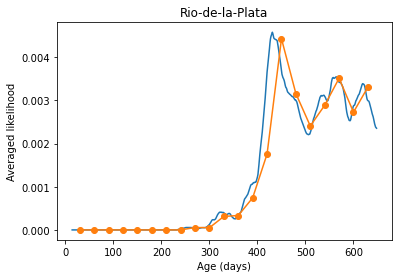

In [249]:
plt.plot(t_arr, b[:, 60, 50])
plt.plot(t_c, c[:, 60, 50], 'o-')
plt.xlabel('Age (days)')
plt.ylabel('Averaged likelihood')
plt.title('Rio-de-la-Plata')

In [250]:
avg_likelihood = {}
for loc in sources:
    mean, new_time = average_field(likelihood[loc], window=30)

    avg_likelihood[loc] = mean

In [251]:
# Normalizing constant (sum of all hypothesis)
normalizing_constant = np.zeros((time, *number_bins))
time = len(new_time)

for t in range(time):
    total = np.zeros((number_sources, *number_bins))

    for j, loc in enumerate(sources):
        total[j] = avg_likelihood[loc][t]*priors['Mean'][loc]

    normalizing_constant[t] = np.sum(total, axis=0)

# Posterior probability
for k, loc in enumerate(sources):
    aux = np.zeros((time, *number_bins))

    for t in range(time):
        aux[t] = avg_likelihood[loc][t]*priors['Mean'][loc]/normalizing_constant[t]

    posterior[loc] = aux

# Saving the avg_likelihood, posteior probabilityand parameters
# np.save('../data/analysis/posterior_smoc.npy', posterior, allow_pickle=True)
# np.save('../data/analysis/avg_likelihood_smoc.npy', avg_likelihood, allow_pickle=True)
# np.save('../data/analysis/params_smoc.npy', parameter, allow_pickle=True)


/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Rio-de-la-Plata')

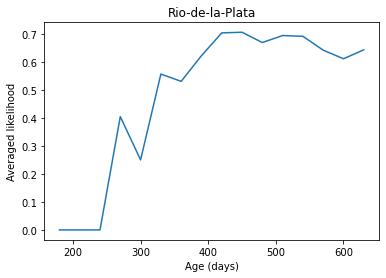

In [253]:
plt.plot(new_time, posterior['Rio-de-la-Plata'][:, 60, 50])
plt.xlabel('Age (days)')
plt.ylabel('Averaged likelihood')
plt.title('Rio-de-la-Plata')

In [254]:
posterior['Rio-de-Janeiro'].shape

(21, 120, 90)

Text(0.5, 1.0, 'Sampling location A')

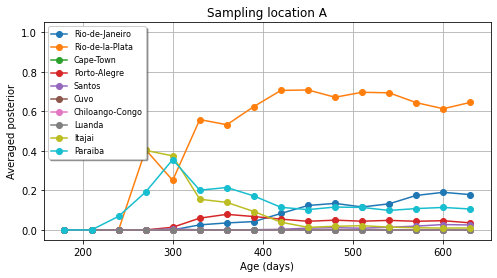

In [264]:
i_lon = 60
i_lat = 50
plt.figure(figsize=(8,4))
for loc in sources:
    
    plt.plot(new_time, posterior[loc][:, i_lon, i_lat], 'o-', label=loc)

#plt.title(f'Sampling location B ({lat:0.1f} lat, {lon:0.1f} lon)')
plt.legend(shadow=True, fontsize=8, loc='upper left')
plt.grid()
plt.xlabel('Age (days)')
plt.ylabel('Averaged posterior')
plt.title('Sampling location A')

Text(0.5, 1.0, 'Sampling location B')

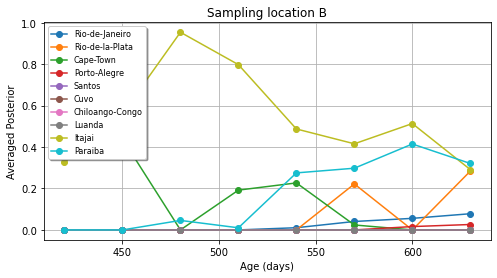

In [265]:
i_lon = 90
i_lat = 50
plt.figure(figsize=(8,4))
for loc in sources:
    
    plt.plot(new_time, posterior[loc][:, i_lon, i_lat], 'o-', label=loc)

#plt.title(f'Sampling location B ({lat:0.1f} lat, {lon:0.1f} lon)')
plt.legend(shadow=True, fontsize=8, loc='upper left')
plt.grid()
plt.xlabel('Age (days)')
plt.ylabel('Averaged Posterior')
plt.title('Sampling location B')

Text(0.4, 0.225, 'Months since release: 19')

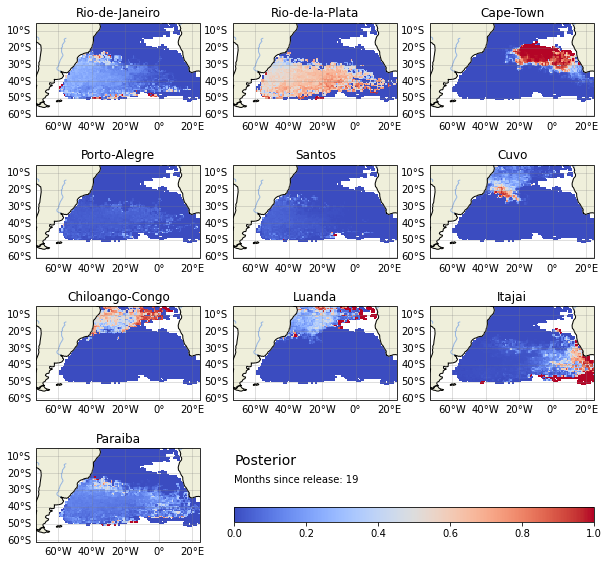

In [267]:
y,x = np.meshgrid(params['lat_range'], params['lon_range'])
t=19
labels=list(posterior.keys())

fig,ax = plt.subplots(ncols=3,nrows=4,figsize=(10,10),
                      subplot_kw={'projection': ccrs.PlateCarree()})

ax = ax.reshape(12)

for k, loc in enumerate(sources):
    
    z = posterior[loc][t] #np.ma.masked_array(prob[loc][t], mask=prob['dimensions']['mask'])
    
    ax[k].set_extent([-73.0, 24.916666,-60.916664, -5.0833335], crs=ccrs.PlateCarree())
    #ax[k].add_feature(cfeature.OCEAN)
    ax[k].add_feature(cfeature.LAND, zorder=1)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].add_feature(cfeature.RIVERS)
    ax[k].set_title(loc)
    im = ax[k].pcolormesh(x,y,z,cmap='coolwarm', vmax=1)
    gl = ax[k].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
#     ax[k].scatter(river_sources[loc][1], river_sources[loc][0], 
#                s=50, marker='o', color='yellow', edgecolors='k', zorder=3)
    
ax[-2].axis('off')
ax[-1].axis('off')
bar_ax = fig.add_axes([0.4, 0.17, 0.5, 0.02])
fig.colorbar(im, cax=bar_ax, orientation='horizontal')
fig.text(0.4,0.25,'Posterior', fontsize=14)
fig.text(0.4,0.225,f'Months since release: {t:0.0f}')
# fig.text(0.4,0.2,f'Current date: {time_range[t]}')

# Delayed realese analysis

In [270]:
plata = xr.load_dataset('../data/simulations/source_Rio-de-la-Plata_K10_N5000.nc')
plata

<xarray.Dataset>
Dimensions:     (obs: 467, traj: 80000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] 2016-04-01T00:30:00 ... NaT
    lat         (traj, obs) float32 -34.81 -34.82 -34.84 -34.81 ... nan nan nan
    lon         (traj, obs) float32 -57.2 -57.25 -57.28 -57.31 ... nan nan nan
    z           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    beaching    (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1.dev292+gc6c2d7bb
    parcels_mesh:           spherical

In [271]:
janeiro = xr.load_dataset('../data/simulations/source_Rio-de-Janeiro_release.nc')
janeiro

<xarray.Dataset>
Dimensions:     (obs: 25, traj: 10000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 1e+04 1e+04 1e+04 ... 2e+04 2e+04 2e+04
    time        (traj, obs) datetime64[ns] 2018-01-01T12:00:00 ... 2018-01-02...
    lat         (traj, obs) float32 -23.12 -23.12 -23.12 ... -23.14 -23.14
    lon         (traj, obs) float32 -43.32 -43.33 -43.34 ... -43.45 -43.45
    z           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

In [297]:
plata['lon']

<xarray.DataArray 'lon' (traj: 80000, obs: 467)>
array([[-57.197968, -57.252647, -57.282116, ...,        nan,        nan,
               nan],
       [-57.191032, -57.265217, -57.319374, ...,        nan,        nan,
               nan],
       [-57.195717, -57.257317, -57.285744, ...,        nan,        nan,
               nan],
       ...,
       [-57.21261 , -57.14825 , -57.154503, ...,        nan,        nan,
               nan],
       [-57.20422 , -57.168877, -57.1803  , ...,        nan,        nan,
               nan],
       [-57.180893, -57.110687, -57.106544, ...,        nan,        nan,
               nan]], dtype=float32)
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      
    standard_name:  longitude
    units:          degrees_east
    axis:           X

In [300]:
count = np.zeros(467)
for i in range(467):
    count[i] = 80000 - np.sum(np.isnan(plata['lon'][:,i].data))

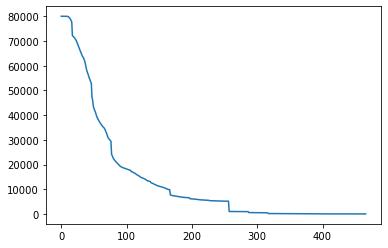

In [301]:
plt.plot(count)

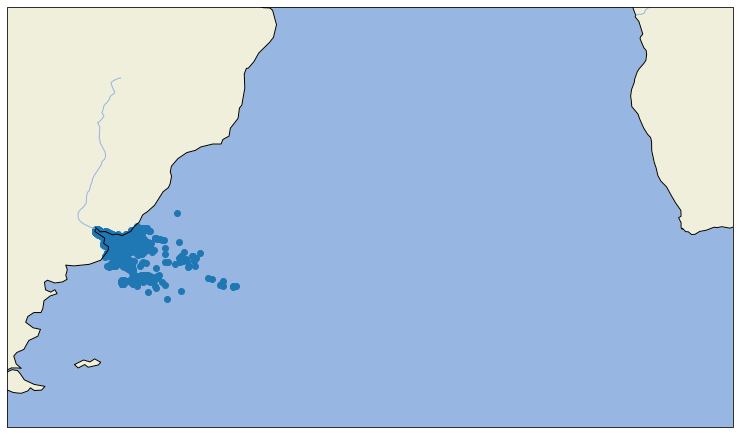

In [280]:
fig = plt.figure(figsize=(13,13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -60, -5), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

t = 100
#ax.text(10,-58,time_range[t].date(), color='white', fontsize=15)

ax.scatter(plata['lon'][:,t], plata['lat'][:,t]);
    
#plt.legend(markerscale=50, shadow=True);